## 1. Loading, reading, and investigating the data. Getting the first insights
For this article, I selected the dataset from the Sloan Digital Sky Survey (SDSS) [https://skyserver.sdss.org/dr17](https://). SDSS is an imaging and spectroscopic survey  dedicated to sky observations, that took place in New Mexico, United States.

At the start, we import all necessary libraries, read the CSV file, get the shape of the data and take a look at the first 10 rows.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing, metrics
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
data = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/skydata.csv')
data.shape

(80000, 18)

In [ ]:
data.head(10)

,dec,u,redshift,z,r,ra,run,specobjid,field,plate,camcol,g,objid,class,fiberid,rerun,i,mjd
0,2.803170,19.35065,0.142265,16.32664,17.04886,182.898466,1458,583309923396381000,388,518,4,17.89648,1237651736831980000,STAR,341,301,16.63305,52282
1,23.891666,17.57148,0.000032,15.88743,16.04065,270.240850,4832,2471445199432210000,126,2195,3,16.38217,1237666227497600000,GALAXY,345,301,15.92649,54234
2,14.323357,18.30611,0.073976,15.00599,15.73859,138.913885,5935,2742700762298610000,151,2436,4,16.52253,1237670965385040000,STAR,31,301,15.32356,54054
3,6.157200,19.52862,0.040765,16.13952,16.88640,159.998722,2986,1125959874568550000,276,1000,2,17.74360,1237658298460930000,STAR,218,301,16.48322,52643
4,-0.395033,18.91353,0.000084,17.14535,17.36865,181.624546,6793,363748710133295000,140,323,3,17.80134,1237674649929380000,GALAXY,302,301,17.21479,51615
5,51.092334,16.78492,0.000040,15.54251,15.57710,181.778987,2964,3258477002100860000,308,2894,6,15.76060,1237658206121230000,GALAXY,446,301,15.51511,54539
6,0.891496,19.43205,0.001170,18.09884,18.24911,132.673009,1239,4292144942145620000,82,3812,6,18.52442,1237650797287830000,GALAXY,780,301,18.13656,55513
7,33.746622,19.43446,0.082736,15.88185,16.65152,161.128566,4550,2279994098163150000,39,2025,6,17.58085,1237665017921730000,STAR,170,301,16.21602,53431
8,50.089984,19.10431,0.063918,16.83548,17.29159,223.776835,3705,1495195397906260000,153,1328,2,17.81979,1237661386534360000,STAR,1,301,17.00263,52786
9,42.417207,19.34225,-0.001037,18.49664,18.36392,183.092882,3893,1632613191383020000,166,1450,3,18.36205,1237662194525930000,GALAXY,212,301,18.41816,53120


In [ ]:
data['class'].value_counts()

STAR      46004
GALAXY    33996
Name: class, dtype: int64

There are 80,000 instances and 18 attributes in the dataset. The data is perfectly clear, without missing cells, there are two target classes labeled as "STAR" and "GALAXY". The dataset suits well for a Binary Classification exercise. All target features are labeled, which means we make supervised learning here. The target values are distributed 58% to 42%, more or less equally, which is good.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   dec        80000 non-null  float64
 1   u          80000 non-null  float64
 2   redshift   80000 non-null  float64
 3   z          80000 non-null  float64
 4   r          80000 non-null  float64
 5   ra         80000 non-null  float64
 6   run        80000 non-null  int64  
 7   specobjid  80000 non-null  uint64 
 8   field      80000 non-null  int64  
 9   plate      80000 non-null  int64  
 10  camcol     80000 non-null  int64  
 11  g          80000 non-null  float64
 12  objid      80000 non-null  int64  
 13  class      80000 non-null  object 
 14  fiberid    80000 non-null  int64  
 15  rerun      80000 non-null  int64  
 16  i          80000 non-null  float64
 17  mjd        80000 non-null  int64  
dtypes: float64(8), int64(8), object(1), uint64(1)
memory usage: 11.0+ MB


In [ ]:
data.isnull().values.any()

False

The data looks perfectly clear, we do not have missing cells, there are three different data types for numerical values, but it is not a problem, we will fix it in the next steps.

First, let's try to find the meaning of presented features and split them into two groups: the ones that we feed to our learning algorithm; and the features that couldn't influence the learning (e.g. IDs or observation dates).

**u, g, r, i, z** are magnitudes, they are image-specific features and definitely have to participate in the learning. **redshift** is one of the specific features of the spectrograph.

**objid**, **specobjid** and **fiberid** stand for some object- and equipment-specific IDs, **mjd** is just a date of observation. **run, rerun, camcol, field** relate to metadata and define experiment-related IDs. **plate** stands for the serial number of an observation plate. We do not take into account all these features.

**ra** and **dec** are sky coordinates of the observed object. I am not sure about these two columns, but let's assume they do not affect us and we try to train the model without them. (In a real business case these points should be definitely cleared).

Now we investigate **u, g, r, i, z, redshift** values. Let's get some statistics for these features.

In [ ]:
data[['u', 'g', 'r', 'i', 'z', 'redshift']].describe()

,u,g,r,i,z,redshift
count,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000
mean,18.599217,17.255286,16.688952,16.417453,16.249336,0.044789
std,0.850213,0.906773,1.013888,1.074750,1.144420,0.053003
min,10.611810,9.988000,9.005167,8.848403,8.947795,-0.004136
25%,18.151283,16.763295,16.112177,15.781940,15.533245,-0.000033
50%,18.836250,17.414850,16.754960,16.453590,16.264470,0.033506
75%,19.253073,17.907175,17.392215,17.129413,16.994713,0.078770
max,19.599950,19.996050,31.990100,32.101780,29.383740,1.945427


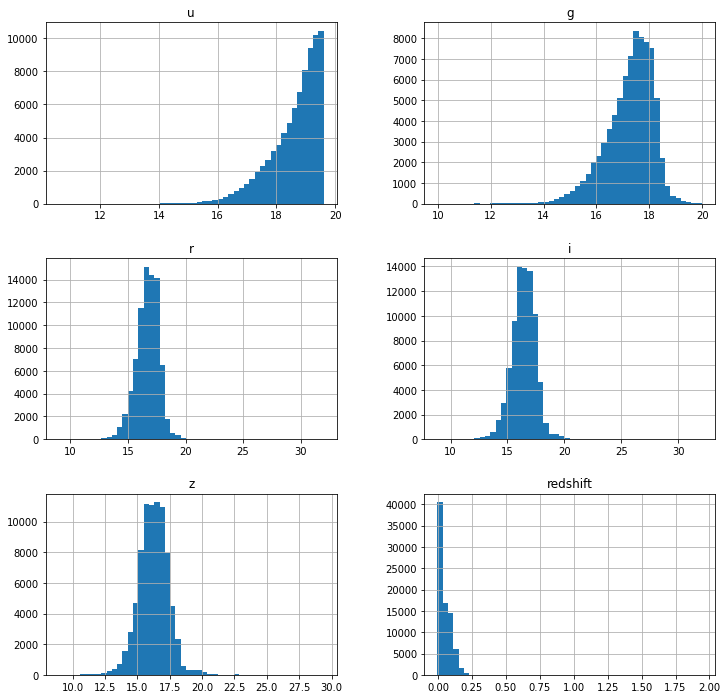

In [ ]:
data[['u', 'g', 'r', 'i', 'z', 'redshift']].hist(bins=50, figsize=(12, 12))
plt.show()

We do not see a lot of anomalies here, **r**, **i** and **z** histograms are belly-shaped. **u** and **g** are negatively skewed, which can be hard for detection of patterns for some ML algorithms. All six parameters have small variability.

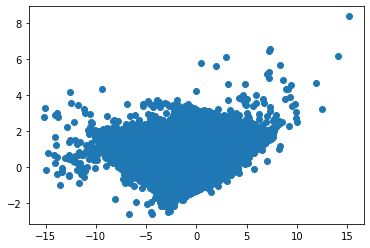

In [ ]:
pca = PCA(n_components=2)
X2D = pca.fit_transform(data[['u', 'g', 'r', 'i', 'z', 'redshift']])
plt.scatter(X2D[:,0], X2D[:,1])

We can see that our data is quite homogeneous. There are some outliers, they could be also removed for better training.

## 2. Pre-processing the data

We create the dataset from the six attributes we discussed and also get labels from the "class" column.

In [ ]:
X = data[['u', 'g', 'r', 'i', 'z', 'redshift']]
y = data[['class']]

ML algorithms do not perform well when the input attributes have very different scales. We do normalization: we rescale attributes so they have values from 0 to 1.

In [ ]:
norm = preprocessing.Normalizer().fit(X)
X = norm.transform(X)
X = np.asarray(X)
X

array([[4.94930179e-01, 4.57736978e-01, 4.36057462e-01, 4.25422320e-01,
        4.17585293e-01, 3.63870420e-03],
       [4.79927015e-01, 4.47443582e-01, 4.38115701e-01, 4.34997667e-01,
        4.33930828e-01, 8.72079304e-07],
       [5.04661154e-01, 4.55491585e-01, 4.33879999e-01, 4.22438490e-01,
        4.13683750e-01, 2.03935225e-03],
       ...,
       [4.97280111e-01, 4.55748032e-01, 4.35269150e-01, 4.25320472e-01,
        4.17908025e-01, 1.53891026e-03],
       [4.87933539e-01, 4.51428561e-01, 4.36421211e-01, 4.30353271e-01,
        4.27160046e-01, 1.62430712e-06],
       [4.71973905e-01, 4.48072372e-01, 4.40287875e-01, 4.37164373e-01,
        4.37613620e-01, 1.95131922e-05]])

Machines do not like words, they like numbers. Therefore we have to encode "STAR" and "GALAXY" values to zeros and ones.

In [ ]:
lb = preprocessing.LabelBinarizer()
y = lb.fit_transform(y)
y = np.asarray(y)
y = np.squeeze(y)
y

array([1, 0, 1, ..., 1, 0, 0])

Next, we split the dataset into test and train subsets with a standard Scikit-learn function. For the test set we take 20% of the data and we shuffle the data (it is True by default here).

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

X_train shape: (64000, 6)
X_test shape: (16000, 6)
y_train shape: (64000,)
y_test shape: (16000,)


Let's check if shuffling went right:

In [ ]:
unique_elements_train, counts_elements_train = np.unique(y_train, return_counts=True)
print(unique_elements_train, counts_elements_train)
unique_elements_test, counts_elements_test = np.unique(y_test, return_counts=True)
print(unique_elements_test, counts_elements_test)

[0 1] [27184 36816]
[0 1] [6812 9188]


Great, the attributes with 0 and 1 labels are distributed more or less equally over train and test sets. Actually, scikit-learn keeps the ratio of zeros and ones in train and test sets the same as in the original set, as expected.

## 3. Training and evaluating the models

The most common methods for binary classification are **Logistic Regression**, **k-Nearest Neighbors**, **Decision Trees**, **Support Vector Machine**, **Naive Bayes**, or more sophisticated methods, such as **Random Forest** or **Neural Network**.

**k-Nearest Neighbors** does not work well with big datasets and with many dimensions. As our dataset is homogeneous and nonlinear, using **Decision Trees** and **SVM** is not a good idea. Instead, we can try **Random Forest** and **Nonlinear SVM**. **Voting Classifiers** could also perform well in this task.

We start with a simple algorithm and move on to more complex ones. I would like to try the next four algorithms:
* **Logistic Regression**
* **Nonlinear SVM**
* **Random Forest**
* **Neural Network**

### 3.1. Logistic Regression

Let's start with Logistic Regression Classifier. We pass data and labels to sklearn **LogisticRegression()** method and that's it.

In [ ]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train);

Now we have to find out how good the model is. There are many evaluation techniques: RMSE, Cross-Validation, Confusion Matrix, Precision, Accuracy, and Recall. Let's make predictions for the test set and build the Confusion Matrix. 

In [ ]:
y_pred = log_reg.predict(X_test)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print('Confusion matrix')
print(cnf_matrix)

Confusion matrix
[[4588 2224]
 [1262 7926]]


For class "zero", 4520 entities were correctly classified and 2292 misclassified. For class "one", 7888 entities were correctly classified and 1300 misclassified. Well, the performance of this model is not so good. It is worth taking a look at one more metric: Precision, Recall, and F1 Score.

In [ ]:
print('Precision:', metrics.precision_score(y_test, y_pred))
print('Recall:', metrics.recall_score(y_test, y_pred))
print('F1 Score:', metrics.f1_score(y_test, y_pred))

Precision: 0.7808866995073892
Recall: 0.8626469307792773
F1 Score: 0.8197331678560348


### 3.2. Nonlinear SVM

Now we do Nonlinear SVM Classification with Gaussian RBF Kernel. There are two important hyperparameters here: **gamma** and **C**. They act like regularization hyperparameters and therefore affect underfitting or overfitting. **Gamma** defines the smoothness of the decision boundary of our classifier. **C** defines margin violations, in other words, it sets the width of the decision boundary. We apply default values first.

In [ ]:
svm_clf = SVC(kernel='rbf', gamma='scale', C=1)
svm_clf.fit(X, y)

y_pred = svm_clf.predict(X_test)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)

print('Confusion matrix')
print(cnf_matrix)
print('---------------')
print('Precision:', metrics.precision_score(y_test, y_pred))
print('Recall:', metrics.recall_score(y_test, y_pred))
print('F1 Score:', metrics.f1_score(y_test, y_pred))

Confusion matrix
[[6564  248]
 [ 646 8542]]
---------------
Precision: 0.9717861205915813
Recall: 0.9296909011754463
F1 Score: 0.9502725553454222


Well, this model looks much better! Let's skip hyperparameters tuning and try next models.

### 3.3. Random Forest

Random Forest is an ensemple learning algorithm of Decision Trees. Let's try it also with default parameters.

In [ ]:
rnd_clf = RandomForestClassifier()
rnd_clf.fit(X_train, y_train)

y_pred = rnd_clf.predict(X_test)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)

print('Confusion matrix')
print(cnf_matrix)
print('---------------')
print('Precision:', metrics.precision_score(y_test, y_pred))
print('Recall:', metrics.recall_score(y_test, y_pred))
print('F1 Score:', metrics.f1_score(y_test, y_pred))

Confusion matrix
[[6806    6]
 [  56 9132]]
---------------
Precision: 0.9993434011818779
Recall: 0.9939050936003483
F1 Score: 0.9966168285496018


Great, this classifier is even better than Nonlinear SVM. We could stop here, but let's try something else: a Neural Network.

### 3.4. Neural Network

Wi will build a very simple Neural Network just with a couple of Dense layers, and I assume it will perform good enough.

First, we change the data and labels to TF tensors.

In [ ]:
X_train = tf.constant(X_train)
y_train = tf.constant(y_train)
X_test = tf.constant(X_test)
y_test = tf.constant(y_test)

Let's build and train the model now. We choose the sequential model because it will have a linear architecture, we make four dense layers. For binary classification, we have to choose one neuron and sigmoid activation function in the last layer. The loss function has to be "Binary Crossentropy". We train over 50 epochs.

In [ ]:
# Create the model
model = tf.keras.Sequential([
                               tf.keras.layers.Dense(128, activation="relu"),
                               tf.keras.layers.Dense(256, activation="relu"),
                               tf.keras.layers.Dense(128, activation="relu"),
                               tf.keras.layers.Dense(1, activation="sigmoid")
])

# Compile the model
model.compile(loss="binary_crossentropy",
              optimizer="Adam",
              metrics=["accuracy"])

# Fit the model
history = model.fit(X_train, 
                    y_train, 
                    epochs=50, 
                    validation_data=(X_test, y_test),
                    verbose=0)

In [ ]:
model.evaluate(X_test, y_test)

500/500 [==============================] - 0s 818us/step - loss: 0.0294 - accuracy: 0.9942


[0.029379412531852722, 0.9941874742507935]

After 50 epochs we have reached about 95% of accuracy. Now we evaluate the model on test data and look at model summary.

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (32, 128)                 896       
                                                                 
 dense_1 (Dense)             (32, 256)                 33024     
                                                                 
 dense_2 (Dense)             (32, 128)                 32896     
                                                                 
 dense_3 (Dense)             (32, 1)                   129       
                                                                 
Total params: 66,945
Trainable params: 66,945
Non-trainable params: 0
_________________________________________________________________


Our model has 66,817 neurons. Now we have to take a look at training curves:

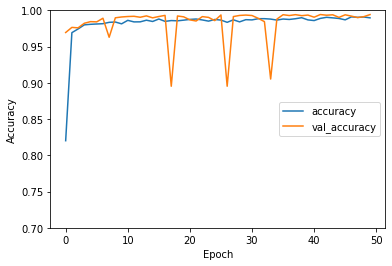

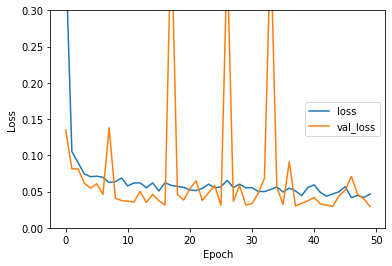

In [ ]:
# Check accuracy and loss
plt.figure(0)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.7, 1])
plt.legend(loc='center right')

plt.figure(1)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 0.3])
plt.legend(loc='center right')

We can see that validation curves fluctuate over epochs. It is not a good sign, it means the model cannot apply well weights after training on the test data. This model needs fine-tuning: adjusting batch size, learning rate, activation function, etc. Let's change the learning rate from 0.001 (default value) to 0.0001, and apply the ELU activation function instead of RELU (it means we add some significance to negative weights).

In [ ]:
# Create the model
model_2 = tf.keras.Sequential([
                               tf.keras.layers.Dense(128, activation="elu"),
                               tf.keras.layers.Dense(256, activation="elu"),
                               tf.keras.layers.Dense(128, activation="elu"),
                               tf.keras.layers.Dense(1, activation="sigmoid")
])

# Compile the model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])

# Fit the model
history_2 = model_2.fit(X_train, 
                        y_train, 
                        epochs=50, 
                        validation_data=(X_test, y_test),
                        verbose=0)

In [ ]:
model_2.evaluate(X_test, y_test)

500/500 [==============================] - 0s 863us/step - loss: 0.0318 - accuracy: 0.9926


[0.03176833316683769, 0.992562472820282]

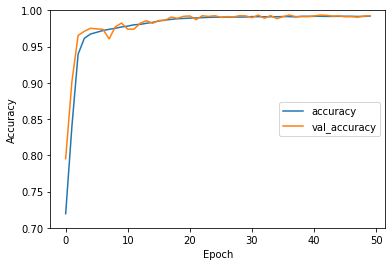

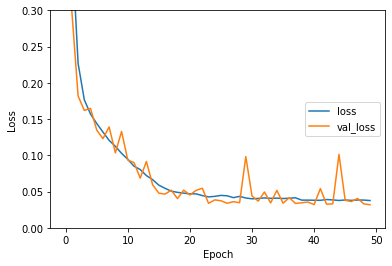

In [ ]:
# Check accuracy and loss
plt.figure(0)
plt.plot(history_2.history['accuracy'], label='accuracy')
plt.plot(history_2.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.7, 1])
plt.legend(loc='center right')

plt.figure(1)
plt.plot(history_2.history['loss'], label='loss')
plt.plot(history_2.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 0.3])
plt.legend(loc='center right')

Now validation curves look better than before, but they are still not ideal. Let's stop here.

In [ ]:
y_pred = model.predict(X_test)
y_pred = tf.constant(y_pred, dtype = tf.int64)
y_pred = tf.squeeze(y_pred)
cnf_matrix = tf.math.confusion_matrix(y_test, y_pred)
print('Confusion matrix')
print(cnf_matrix)
print('---------------')
print('Precision:', metrics.precision_score(y_test, y_pred))
print('Recall:', metrics.recall_score(y_test, y_pred))
print('F1 Score:', metrics.f1_score(y_test, y_pred))

Confusion matrix
tf.Tensor(
[[6812    0]
 [ 175 9013]], shape=(2, 2), dtype=int32)
---------------
Precision: 1.0
Recall: 0.9809534175010883
F1 Score: 0.9903851436734246


## 4. Conclusions

We can see that **Nonlinear SVM with Gaussian RBF Kernel** as well as **Random Forest** show very good performance. **Neural Network** with dense layers is good as well, but it needs some tuning. For this problem, I would recommend choosing **Random Forest** model.

We should save now the Random Forest Model in binary format and use it further for predictions in any ML application. We use a pickle library for "pickling" the model:

In [ ]:
import pickle

with open('/content/gdrive/My Drive/saved_model.pkl', 'wb') as f:
    pickle.dump(rnd_clf, f)